In [1]:
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import sys
sys.path.append('../')

from src.pySQL_funcs import *

In [2]:
#FOR SECURITY I EXCLUDE THE AWS ADDRESS AND PASSWORD HERE
#SYNTAX IS "dbname= user= host= port=5432 password="
with open('../src/pw') as pw_file:
    pw = pw_file.readline()
    
conn = psycopg2.connect(pw)
cur = conn.cursor()

## BASIC QUERY EXAMPLES

In [3]:
# Example Query to test connection
query = """
SELECT * FROM pokemon LIMIT 10;
"""
#cur.execute(query)
#cur.fetchall()
pretty_query(cur, query, conn)

,id,name,type_1,type_2
0,0,Gliscor,Ground,Flying
1,1,Fletchinder,Fire,Flying
2,2,Poliwrath,Water,Fighting
3,3,Cresselia,Psychic,None
4,4,Frogadier,Water,None
5,5,Sceptile,Grass,None
6,6,Lapras,Water,Ice
7,7,Sharpedo,Water,Dark
8,8,Slowbro,Water,Psychic
9,9,Omastar,Rock,Water


In [4]:
## Find the 10 most popular abilities for pokemon movesets
query = """
SELECT n.name, SUM(count) AS total_number_pokemon_used
  FROM battle_abilities b 
  JOIN abilities n ON b.ability_id=n.id 
  GROUP BY n.name ORDER BY COUNT(*) DESC LIMIT 10;
"""
pretty_query(cur, query, conn)

,name,total_number_pokemon_used
0,levitate,75154300.0
1,innerfocus,8890850.0
2,intimidate,64265100.0
3,waterabsorb,15057900.0
4,regenerator,44654700.0
5,pressure,28741300.0
6,technician,27212000.0
7,sturdy,20654900.0
8,synchronize,16686100.0
9,flashfire,32312100.0


In [5]:
## Find the 10 most popular pokemon used as a percent of month 
query = """
SELECT p.name, usage, month 
  FROM battles b 
  JOIN pokemon p ON b.id=p.id
 ORDER BY usage DESC LIMIT 10;
"""
pretty_query(cur, query, conn)

,name,usage,month
0,Dragapult,0.375045,01-2020
1,Dragapult,0.365004,12-2019
2,Dragapult,0.345182,02-2020
3,Cinderace,0.315563,06-2020
4,Landorus-Therian,0.311849,06-2019
5,Darmanitan-Galar,0.310821,12-2019
6,Landorus-Therian,0.303670,11-2017
7,Landorus-Therian,0.301281,12-2017
8,Dragapult,0.298842,03-2020
9,Landorus-Therian,0.297543,02-2019


In [6]:
#Find Pokemon with the most months on as number 1 in usage
query = """
SELECT name, COUNT(*) AS months_on_top
  FROM (
        SELECT p.name, b.month, 
               RANK() OVER(PARTITION BY month ORDER BY usage DESC) r
          FROM battles b 
          JOIN pokemon p ON b.id=p.id 
       ) monthly_rank
  WHERE r=1
  GROUP BY name
 ORDER BY months_on_top DESC LIMIT 10;
"""
pretty_query(cur, query, conn)

,name,months_on_top
0,Landorus-Therian,46
1,Dragapult,4
2,Garchomp,3
3,Gengar,3
4,Clefable,2
5,Cinderace,1


## MEDIUM DIFFICULTY EXAMPLES

In [7]:
#Let's visual how 'centralized' the metagame has been over time
query = """
SELECT name, month, usage, r
  FROM (
        SELECT p.name, b.month, b.usage,
               RANK() OVER(PARTITION BY month ORDER BY usage DESC) r
          FROM battles b 
          JOIN pokemon p ON b.id=p.id 
       ) monthly_rank
  WHERE r IN (1,2,3)
  ORDER BY TO_DATE(month, 'MM YYY')
  ;
"""
top_3_overtime = pretty_query(cur, query, conn)

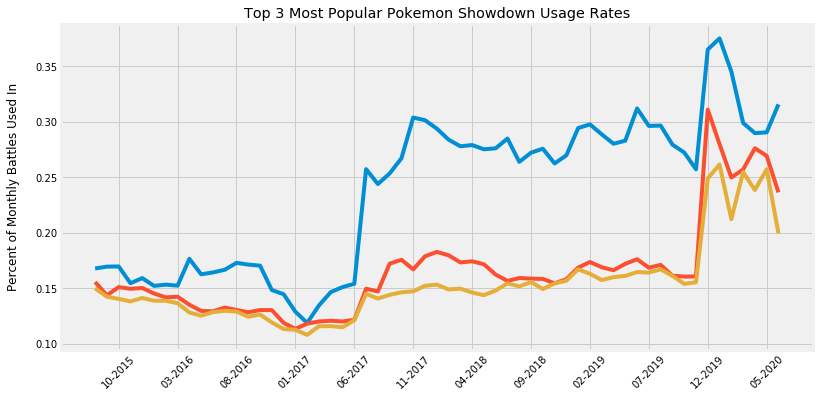

In [8]:
ranks = range(1,4)
fig, ax = plt.subplots(figsize=(12, 6))
for r in ranks:
    sub = top_3_overtime[top_3_overtime['r'] == r]
    x, y = sub['month'], sub['usage']
    ax.plot(x, y)
ax.set_title('Top 3 Most Popular Pokemon Showdown Usage Rates')
ax.set_ylabel('Percent of Monthly Battles Used In', labelpad=15)
plt.xticks(ticks=range(2, sub.shape[0], 5),rotation=45)
plt.tight_layout;

In [9]:
#It looks like we're getting more centralized with each generation
#Let's look at it from another perspective
#Get a distinct count of all Pokemon used each month (we'll cut off at 100)
query = """
SELECT COUNT(*), month
  FROM battles
  WHERE count >= 100
  GROUP BY month
  ORDER BY TO_DATE(month, 'MM YYY')
  ;
"""
distinct_usage = pretty_query(cur, query, conn)

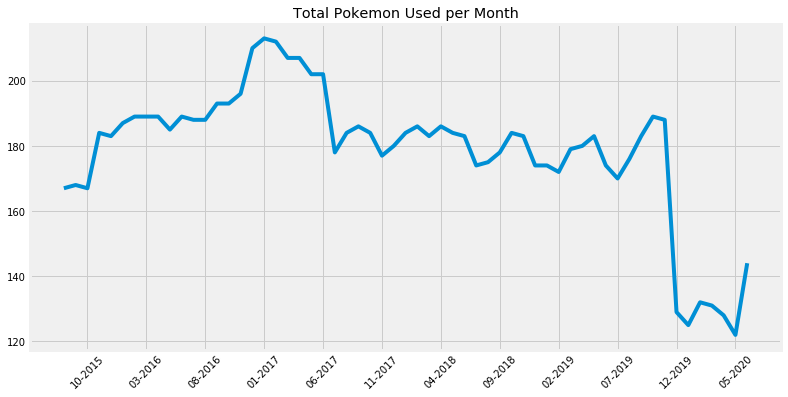

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(distinct_usage['month'], distinct_usage['count'])
ax.set_title('Total Pokemon Used per Month')

plt.xticks(ticks=range(2, sub.shape[0], 5),rotation=45)
plt.tight_layout;

In [11]:
## Revise our top usage query to include it's most common nature that month & count of that nature
query = """
WITH max_usage(id,name,usage,month) 
  AS (
      SELECT p.id, p.name, usage, b.month
        FROM battles b 
        JOIN pokemon p ON b.id=p.id
       ORDER BY usage DESC LIMIT 20
     ),
     usage_and_natures(name,usage,month,nature,count)  
  AS (
      SELECT mu.name, mu.usage, mu.month, n.name AS nature, bn.count
      FROM max_usage AS mu
      JOIN battle_natures AS bn ON mu.id=bn.id AND mu.month=bn.month
      JOIN natures AS n ON bn.nature_id=n.id
     )
SELECT name, usage, un.month, nature, count
  FROM usage_and_natures AS un
  JOIN (SELECT month, MAX(count) FROM usage_and_natures GROUP BY month) t
    ON un.month=t.month AND un.count=t.max
  ORDER BY usage DESC;
"""
pretty_query(cur, query, conn)

,name,usage,month,nature,count
0,Dragapult,0.375045,01-2020,Timid,664829.0
1,Dragapult,0.345182,02-2020,Timid,615545.0
2,Cinderace,0.315563,06-2020,Jolly,1100350.0
3,Landorus-Therian,0.311849,06-2019,Jolly,872810.0
4,Darmanitan-Galar,0.310821,12-2019,Jolly,1525520.0
5,Landorus-Therian,0.303670,11-2017,Impish,521557.0
6,Landorus-Therian,0.301281,12-2017,Impish,543601.0
7,Dragapult,0.298842,03-2020,Timid,464004.0
8,Landorus-Therian,0.297543,02-2019,Jolly,481563.0
9,Landorus-Therian,0.296457,08-2019,Jolly,698466.0


In [12]:
#Find the most common matchup every month as a monthly percentage
query = """
SELECT p1.name AS Pokemon, 
       p2.name AS Counter, 
       100*(t.battles/u.num_battles) AS Pct_of_Monthly_Battles, 
       100*c.check_pct,
       c.month AS Month
  FROM counters AS c
  JOIN (SELECT MAX(num_battles) AS battles, month FROM counters GROUP BY month) t
    ON c.num_battles=t.battles AND c.month=t.month
  JOIN pokemon AS p1
    ON c.id=p1.id
  JOIN pokemon AS p2
    ON c.counter_id=p2.id
  JOIN users AS u
    ON c.month=u.month
;
"""
matchups = pretty_query(cur, query, conn)
matchups

,pokemon,counter,pct_of_monthly_battles,?column?,month
0,Ferrothorn,Heatran,2.574289,89.025015,08-2015
1,Ferrothorn,Heatran,2.444835,88.905948,09-2015
2,Ferrothorn,Heatran,2.373806,89.203155,10-2015
3,Ferrothorn,Heatran,2.367024,89.084893,11-2015
4,Ferrothorn,Heatran,2.435471,89.049679,12-2015
5,Ferrothorn,Heatran,2.493324,89.336884,01-2016
6,Ferrothorn,Heatran,2.436350,89.106566,02-2016
7,Ferrothorn,Heatran,2.334695,89.535242,03-2016
8,Excadrill,Landorus-Therian,2.636116,61.494255,04-2016
9,Excadrill,Landorus-Therian,2.345363,62.111014,05-2016


In [13]:
## Let's Look at Landorus' Most Popular natures & items
query = """

WITH lando_nature(name, month, nature, count)
  AS 
	(SELECT p.name, b.month, n.name, bn.count 
      FROM (SELECT * FROM pokemon WHERE name='Landorus-Therian') p 
	  JOIN battles b ON p.id=b.id
	  JOIN battle_natures bn ON b.id=bn.id AND b.month=bn.month
	  JOIN natures n ON bn.nature_id=n.id
      ),

      lando_item(name, month, item, count)
  AS 
	(SELECT p.name, b.month, i.name, bi.count 
      FROM (SELECT * FROM pokemon WHERE name='Landorus-Therian') p 
	  JOIN battles b ON p.id=b.id
	  JOIN battle_items bi ON b.id=bi.id AND b.month=bi.month
	  JOIN items i ON bi.item_id=i.id)

SELECT ln.month,
       ln.nature, ln.count AS nature_count,
       li.item,li.count AS item_count
  FROM (SELECT ln.name, ln.month, ln.nature, ln.count
          FROM lando_nature ln
          WHERE ln.count IN 
		(SELECT MAX(count)
          	FROM lando_nature
	 	GROUP BY month)) ln
  JOIN (SELECT * FROM lando_item li
          WHERE count IN 
                        (SELECT MAX(count) FROM lando_item GROUP BY month)
                        ) li
        
    ON ln.month=li.month
;
"""
pretty_query(cur, query, conn)

,month,nature,nature_count,item,item_count
0,08-2015,Jolly,275210.0,choicescarf,294933.0
1,10-2015,Jolly,236347.0,choicescarf,262833.0
2,11-2015,Jolly,167246.0,choicescarf,184707.0
3,12-2015,Impish,165979.0,choicescarf,176194.0
4,01-2016,Impish,233486.0,choicescarf,241442.0
5,02-2016,Impish,225733.0,choicescarf,227736.0
6,09-2015,Jolly,236562.0,choicescarf,256053.0
7,03-2016,Impish,231734.0,choicescarf,247478.0
8,04-2016,Impish,220810.0,choicescarf,168127.0
9,05-2016,Impish,281200.0,choicescarf,228210.0


In [28]:
#WHO HAS BEEN THE BIGGEST THORN IN LANDORUS' SIDE?
query = """
WITH lando_counters(month, counter_id, check_pct)
AS
    (SELECT c.month, c.counter_id, c.check_pct
      FROM counters c
     JOIN battles b ON c.counter_id=b.id AND c.month=b.month
     WHERE c.id=(SELECT id FROM pokemon WHERE name='Landorus-Therian')
      AND check_pct >=0.75 AND num_battles >=1000 AND b.usage > 0.05),
      
      top_threats(counter_id, check_pct)
AS 
    (SELECT counter_id, AVG(check_pct)
       FROM lando_counters
       WHERE counter_id IN (SELECT counter_id FROM lando_counters GROUP BY counter_id HAVING COUNT(*) > 5)
       GROUP BY counter_id)

SELECT name FROM top_threats
  JOIN pokemon ON top_threats.counter_id=pokemon.id
  WHERE check_pct=(SELECT MAX(check_pct) FROM top_threats);
"""
pretty_query(cur, query, conn)

,name
0,Serperior


## HARD DIFFICULTY EXAMPLES

In [14]:
#Find how the monthly top 2 interact competitively 
#If their competitive interaction is not towards either: 

query = """
WITH monthly_rank(id,name,month,r)
  AS 
    (
     SELECT p.id, p.name, b.month, 
            RANK() OVER(PARTITION BY month ORDER BY usage DESC) r
       FROM battles b 
       JOIN pokemon p ON b.id=p.id 
     ),
     top_2(rank1_id, rank1_mon, rank2_id, rank2_mon, month)
  AS 
    (
     SELECT mr1.id AS rank1_id, mr1.name AS rank1_mon,
            mr2.id AS rank2_id, mr2.name AS rank2_mon,
            mr1.month
       FROM (SELECT * FROM monthly_rank WHERE r=1) AS mr1
       JOIN (SELECT * FROM monthly_rank WHERE r=2) AS mr2
         ON mr1.month=mr2.month
      )

SELECT TO_DATE(t.month, 'MM YYYY') AS month, 
       t.rank1_mon, t.rank2_mon, 
       u.num_battles/users.num_battles AS pct_of_battles, 
       check_pct, alpha_poke
  FROM top_2 AS t
 FULL OUTER JOIN(
                 SELECT t.month, 
                        rank1_id, rank1_mon, 
                        rank2_id, rank2_mon, 
                        c.num_battles, c.check_pct,
                        rank2_mon AS alpha_poke
                   FROM top_2 AS t
                   JOIN counters AS c ON t.rank1_id=c.id AND t.month=c.month
                  WHERE t.rank2_id=c.counter_id
        UNION ALL
                 SELECT t.month, 
                        rank1_id, rank1_mon, 
                        rank2_id, rank2_mon, 
                        c.num_battles, c.check_pct,
                        rank2_mon AS alpha_poke
                   FROM top_2 AS t
                   JOIN counters AS c ON t.rank2_id=c.id AND t.month=c.month
                  WHERE t.rank1_id=c.counter_id
                ) u
    ON t.month=u.month
  JOIN users 
    ON t.month=users.month
    
ORDER BY month
;
"""
top_2_interactions = pretty_query(cur, query, conn)
top_2_interactions

,month,rank1_mon,rank2_mon,pct_of_battles,check_pct,alpha_poke
0,2015-08-01,Garchomp,Scizor,0.019179,0.659791,Scizor
1,2015-09-01,Garchomp,Scizor,0.017720,0.654862,Scizor
2,2015-10-01,Garchomp,Landorus-Therian,NaN,NaN,None
3,2015-11-01,Landorus-Therian,Garchomp,NaN,NaN,None
4,2015-12-01,Landorus-Therian,Garchomp,NaN,NaN,None
5,2016-01-01,Landorus-Therian,Garchomp,NaN,NaN,None
6,2016-02-01,Landorus-Therian,Garchomp,0.019472,0.500635,Garchomp
7,2016-03-01,Landorus-Therian,Garchomp,NaN,NaN,None
8,2016-04-01,Landorus-Therian,Garchomp,NaN,NaN,None
9,2016-05-01,Landorus-Therian,Garchomp,NaN,NaN,None


In [19]:
# FIND THE MONTHLY AVERAGE USAGE FOR EACH TYPE & MOVING AVERAGE
query = """
SELECT month, type, avg_usage,
     AVG(avg_usage) OVER(PARTITION BY type ORDER BY month) AS moving_avg
  FROM
    (SELECT TO_DATE(b.month, 'MM YYYY') AS month, p.type, AVG(b.usage) AS avg_usage
     FROM battles AS b
    JOIN (SELECT id, name, type_1 AS type FROM pokemon 
           UNION ALL 
           SELECT id, name, type_2 AS type FROM pokemon
           WHERE type_2 != 'None') AS p 
    ON b.id=p.id
    GROUP BY b.month, p.type) t

ORDER BY month, avg_usage DESC
;
"""
monthly_type_usage = pretty_query(cur, query, conn)
monthly_type_usage

,month,type,avg_usage,moving_avg
0,2015-08-01,Steel,0.061493,0.061493
1,2015-08-01,Fairy,0.049065,0.049065
2,2015-08-01,Flying,0.048155,0.048155
3,2015-08-01,Fire,0.045899,0.045899
4,2015-08-01,Dragon,0.041707,0.041707
...,...,...,...,...
1059,2020-06-01,Water,0.031567,0.027112
1060,2020-06-01,Rock,0.030581,0.021532
1061,2020-06-01,Psychic,0.027053,0.024836
1062,2020-06-01,Bug,0.021485,0.023324


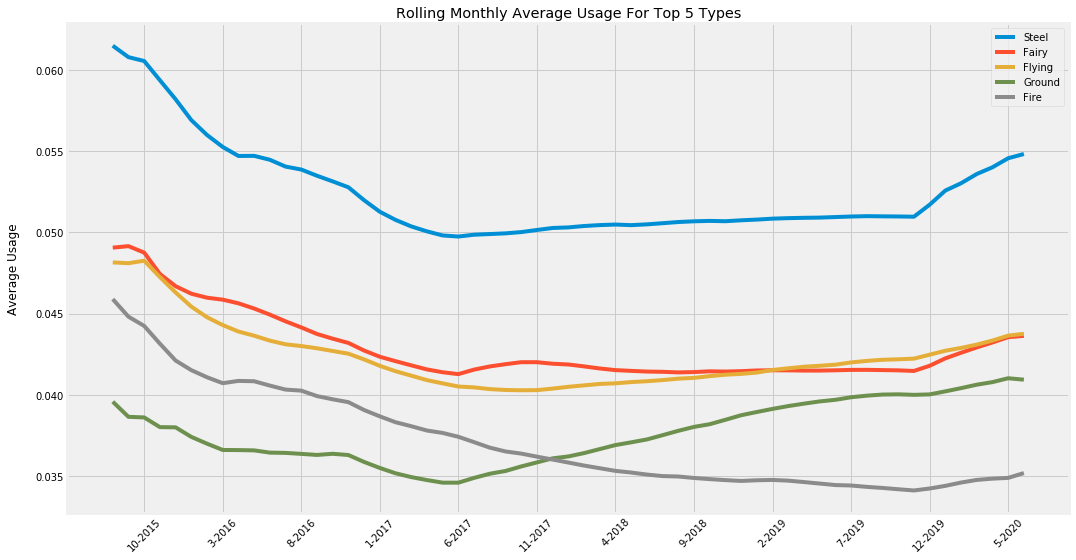

In [61]:
fig, ax = plt.subplots(figsize=(16, 9))
top_5_types = monthly_type_usage.groupby('type')['moving_avg'].mean().sort_values()[-5:].index[::-1]

for type_ in top_5_types:
    sub = monthly_type_usage[monthly_type_usage['type'] == type_]
    x, y = sub['month'].apply(lambda d: f'{d.month}-{d.year}').unique(), sub['moving_avg']
    ax.plot(x, y)

ax.set_title('Rolling Monthly Average Usage For Top 5 Types')
ax.set_ylabel('Average Usage', labelpad=15)
plt.xticks(ticks=range(2, months.shape[0], 5),rotation=45)
ax.legend(top_5_types)
plt.tight_layout;

In [20]:
cur.close()  # Close the cursor
conn.close()

Index(['Fire', 'Ground', 'Flying', 'Fairy', 'Steel'], dtype='object', name='type')